In [1]:
import numpy as np
import tensorflow as tf
import cv2
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns  # for nicer graphics
from sklearn.model_selection import train_test_split
#from planet import planet
from bssfp_data_generator.planet2 import planet

In [59]:
# Function to normalize data
def normalize(data):
    data = (data - np.min(data))/(np.max(data) - np.min(data))
    return data

# Function to preprocess data for PLANEY
def preprocessing(data, gt, t2):
    row = len(data[0,:,0:28][np.where(gt == t2)])
    planet_test = np.zeros((len(data)*row,6),dtype = complex)
    for i in range(len(data)):
        for j in range(6):
            planet_test[row*i:row*(i+1),j] = data[i,:,28*j:28*(j+1)][np.where(gt == t2)]
    return planet_test

# Function for Monte Carlo Simulation of PLANET
def monte_carlo(data):
    predicted_t2 = []
    TR = 3e-3 # TR = relaxation time
    npcs = 6  # npcs = no. of phase cycles, 
    B0 = 3   # B0 = main magnetic field
    alpha = np.deg2rad(30) # alpha = flip angle
    pcs = np.linspace(0, 2*np.pi, npcs, endpoint=False)
    count = 0
    for i in range(len(data)): 
        _, _, temp ,_ = planet(data[i,:], alpha=alpha, TR=TR, T1_guess=2, pcs=pcs, mask=None, pc_axis=0, ret_all=False)
        if temp > 0.07 and temp < 0.12:
            predicted_t2.append(temp)
        else:
            # count number of times PLANET fails
            count = count+1 
        
    predicted_t2  = np.asarray(predicted_t2)
    return (predicted_t2, count)

In [3]:
# Load bSSFP images training data and ground truth 
img_data = np.load('c:\\Users\\yiten\\Documents\\MRI Relaxometry\\img_reg_data\\img_data.npy')
gt_data = np.load('c:\\Users\\yiten\\Documents\\MRI Relaxometry\\img_reg_data\\gt_img_data.npy')
gt_check = gt_data[0]

# Train test split
img_train, img_test, gt_train, gt_test = train_test_split(img_data, gt_data, test_size=0.1, random_state=42)

# Save complex-valued img_test for planet_test
planet_test = img_test

# Take the magnitude of img_data as training and test data
img_train = np.abs(img_train)
img_test = np.abs(img_test)

# Normalize training and test data
img_train = normalize(img_train)
img_test = normalize(img_test)

(-0.5, 167.5, 39.5, -0.5)

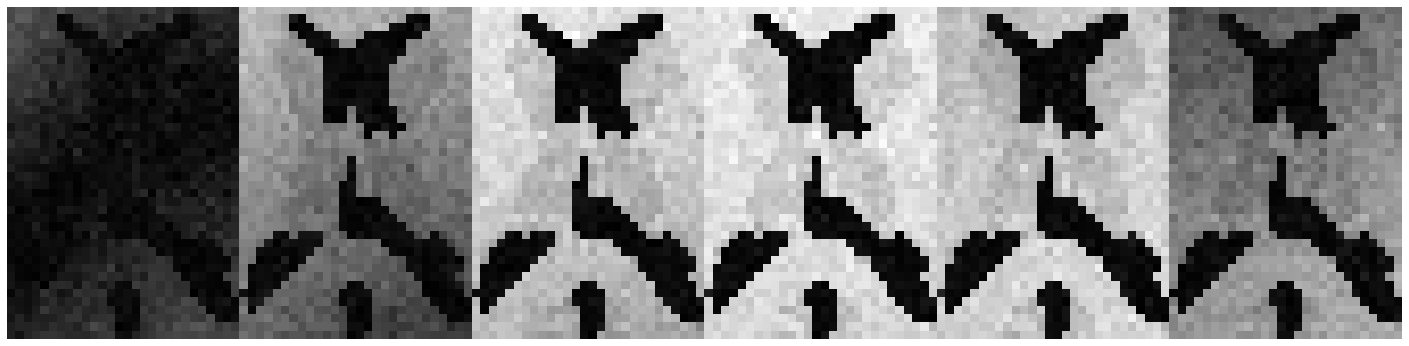

In [4]:
plt.figure(figsize=(25,8))
im = plt.imshow(img_train[2])
plt.imshow(img_train[2],cmap='gray') # greyscale
plt.axis('off')

(-0.5, 27.5, 39.5, -0.5)

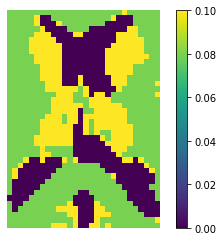

In [5]:
im = plt.imshow(gt_check)
plt.colorbar(im)
plt.axis('off')
# Gray Matter (100ms) in yellow
# White Matter (80ms) in green

In [38]:
def Model():

    def down_block(x, filters):
        x = tf.keras.layers.Conv1D(filters, 3, padding="same", activation=tf.nn.relu, kernel_initializer='he_uniform')(x)
        x = tf.keras.layers.Conv1D(filters, 3, padding="same", activation=tf.nn.relu, kernel_initializer='he_uniform')(x)
        x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.95, epsilon=0.001)(x)
        #x = Dropout(rate=0.0)(x)
        return x

    def max_pool(x):
        return tf.keras.layers.MaxPooling1D(padding="same", strides=2, pool_size=2)(x)

    def up_block(x, filters, skip_connect):
        # x = UpSampling1D(size = 2)(x)
        x = tf.keras.layers.Conv1DTranspose(filters, 3, strides=2, padding="same", activation=tf.nn.relu)(x)
        x = tf.keras.layers.concatenate([x, skip_connect], axis=2)
        x = tf.keras.layers.Conv1D(filters, 3, padding="same", activation=tf.nn.relu, kernel_initializer='he_uniform')(x)
        x = tf.keras.layers.Conv1D(filters, 3, padding="same", activation=tf.nn.relu, kernel_initializer='he_uniform')(x)
        x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.95, epsilon=0.001)(x)
        #x = tf.keras.layers.Dropout(rate=0.0)(x)
        return x 

    def unet():
        fn = [42, 84, 168, 336]
        fdepth = len(fn)

        x_stack = []
        xin = tf.keras.Input(shape=(img_data.shape[1],img_data.shape[2]), name='img')

        x = xin
        for idx in range(fdepth):
            x = down_block(x, fn[idx])

            if(idx < fdepth - 1):
                x_stack.append(x)
                x = max_pool(x)

        for idx in range(fdepth - 1):
            idx = fdepth - idx - 2
            x = up_block(x, fn[idx], x_stack.pop())

        xout = tf.keras.layers.Conv1D(gt_data.shape[2], 1, padding="same", activation='linear')(x)
        return tf.keras.Model(inputs=xin, outputs=xout)

    return unet()

In [39]:
# Setup Unet model
model = Model()
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 40, 168)]    0                                            
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 40, 42)       21210       img[0][0]                        
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 40, 42)       5334        conv1d_15[0][0]                  
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 40, 42)       168         conv1d_16[0][0]                  
_______________________________________________________________________________________

In [40]:
# Define optimizer and train the network
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics='mse')
start=time.time()

# Starts training
history = model.fit(img_train, gt_train, epochs=30, batch_size=10, validation_split=0.1)  
end=time.time()
print('Time Elapsed:%i seconds'%(end-start))

Epoch 1/30
81/81 [==============================] - 3s 37ms/step - loss: 0.1883 - mse: 0.1883 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 2/30
81/81 [==============================] - 2s 22ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 3/30
81/81 [==============================] - 2s 24ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 4/30
81/81 [==============================] - 2s 24ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 5/30
81/81 [==============================] - 2s 25ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 6/30
81/81 [==============================] - 2s 24ms/step - loss: 8.9678e-04 - mse: 8.9678e-04 - val_loss: 8.4450e-04 - val_mse: 8.4450e-04
Epoch 7/30
81/81 [==============================] - 2s 23ms/step - loss: 7.1841e-04 - mse: 7.1841e-04 - val_loss: 6.9484e-04 - val_mse: 6.9484e-04
Epoch 8/30
81/81 [==============================] -

In [50]:
# Save or load trained model 
#model.save('image_regression'); 
model = tf.keras.models.load_model('image_regression')

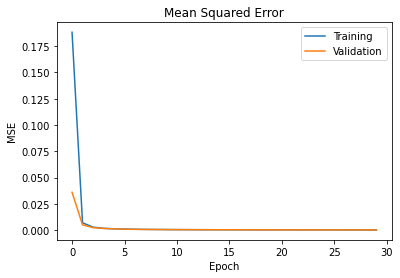

10/10 [==============================] - 0s 11ms/step - loss: 1.3302e-04 - mse: 1.3302e-04
Test MSE:0.000133


In [43]:
# Learning Curve
# MSE for each epoch during training
#print(model.summary())
#print(history.history.keys())
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

# Evaluate model using testing set
test_metric = model.evaluate(img_test, gt_test, batch_size=10)
print('Test MSE:%.6f'%test_metric[1])

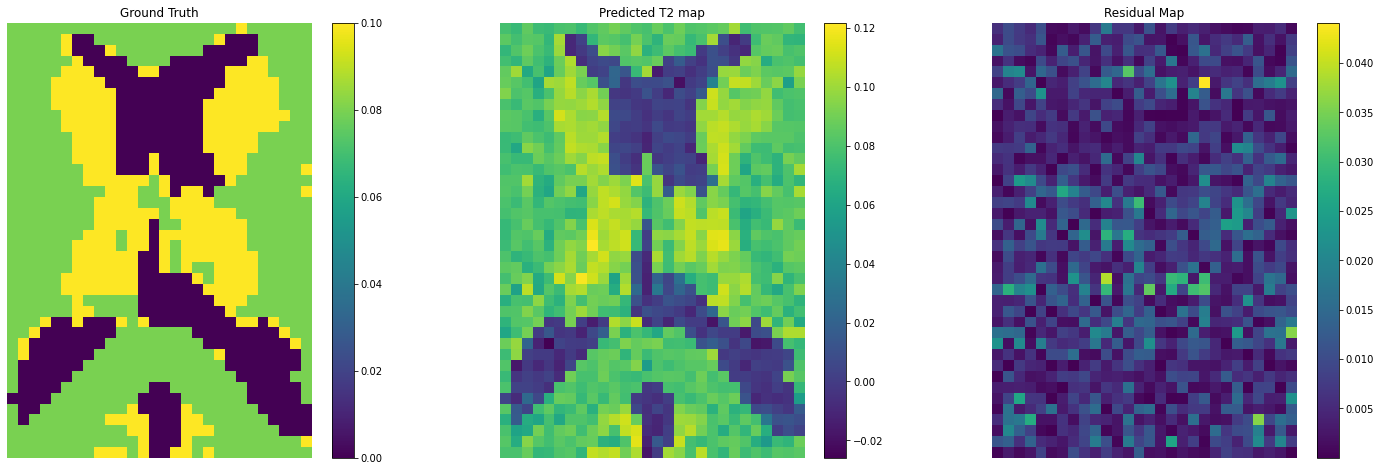

In [51]:
# Comparison between Ground Truth and Mean Predicted T2 map
predicted_t2map = model.predict(img_test)

# Ground Truth 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 8))
im = ax1.imshow(gt_test[0])
ax1.axis('off')
ax1.set_title('Ground Truth')
plt.colorbar(im,ax=ax1)

# Mean Predicted T2 map
im = ax2.imshow(predicted_t2map.mean(axis=0))
ax2.axis('off')
ax2.set_title('Predicted T2 map')
plt.colorbar(im,ax=ax2)

# Residual Map
residual_map = abs(gt_test[0]-predicted_t2map[0])
im = ax3.imshow(residual_map)
ax3.axis('off')
ax3.set_title('Residual Map')
plt.colorbar(im,ax=ax3)

In [70]:
# Split predicted data into gray and white matter
predicted_gm_t2 = []
predicted_wm_t2 = []
for i in range(len(predicted_t2map)):
    predicted_gm_t2.extend(predicted_t2map[i][np.where(gt_check == 0.1)])
    predicted_wm_t2.extend(predicted_t2map[i][np.where(gt_check == 0.08)])

print(len(predicted_gm_t2))
print(len(predicted_wm_t2))

27600
56000


In [60]:
# PLANET : Monte Carlo
planet_gm_test = preprocessing(planet_test,gt_check,0.1)
planet_wm_test = preprocessing(planet_test,gt_check,0.08)
print(planet_gm_test.shape)
print(planet_wm_test.shape)

gm_pdf_p, count_failed_gm = monte_carlo(planet_gm_test)
print('Rejected %d out of %d' %(count_failed_gm,len(planet_gm_test)))
print('PLANET Mean T2 (GM):', gm_pdf_p.mean())

wm_pdf_p, count_failed_wm = monte_carlo(planet_wm_test)
print('Rejected %d out of %d' %(count_failed_wm,len(planet_wm_test)))
print('PLANET Mean T2 (WM):', wm_pdf_p.mean())

(27600, 6)
(56000, 6)
Rejected 25217 out of 27600
PLANET Mean T2 (GM): 0.090064924980556
Rejected 50347 out of 56000
PLANET Mean T2 (WM): 0.09009053771369957


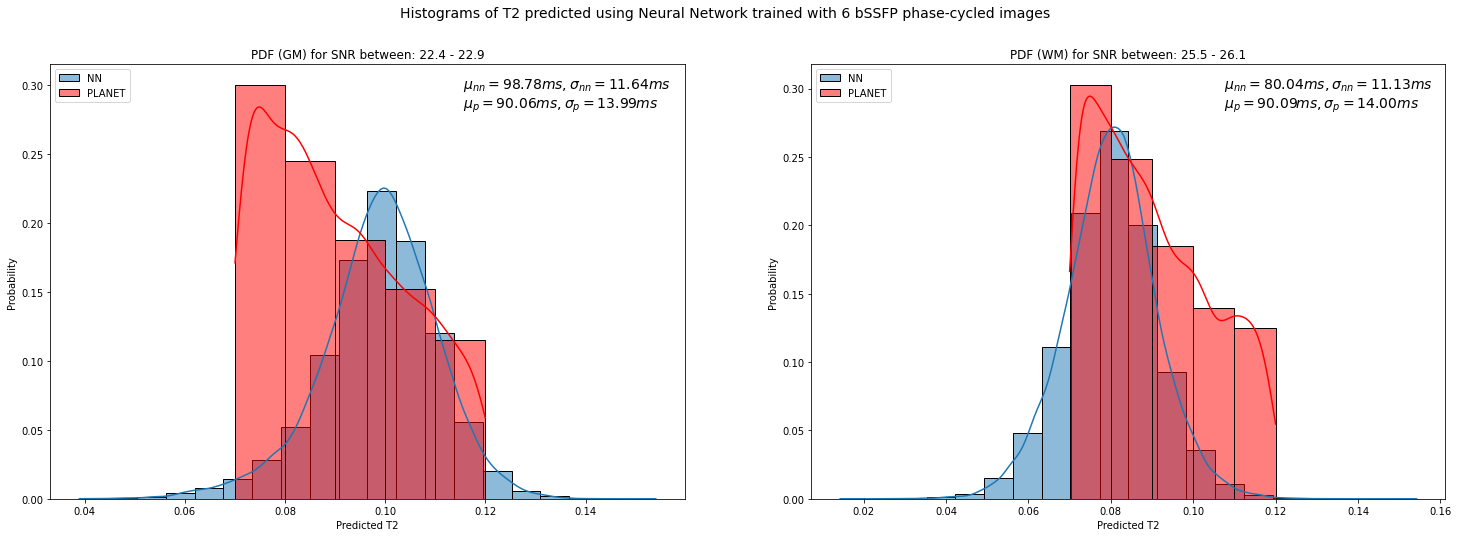

In [68]:
# Histograms
# Parameters for histograms plotting
snr_data = np.load('c:\\Users\\yiten\\Documents\\MRI Relaxometry\\img_reg_data\\snr_img_data.npy')
s = '\n'
gm_str = s.join(['$\mu_{nn} = %.2f ms, \sigma_{nn} = %.2f ms$'%(np.mean(predicted_gm_t2)*1000,np.std(predicted_gm_t2)*1000), '$\mu_{p}  = %.2f ms, \sigma_{p}  = %.2f ms$'%(gm_pdf_p.mean()*1000,gm_pdf_p.std()*1000)])
wm_str = s.join(['$\mu_{nn} = %.2f ms, \sigma_{nn}  = %.2f ms$'%(np.mean(predicted_wm_t2)*1000,np.std(predicted_wm_t2)*1000), '$\mu_{p}  = %.2f ms, \sigma_{p}  = %.2f ms$'%(wm_pdf_p.mean()*1000,wm_pdf_p.std()*1000)])
textbox_height = 0.9
textbox_width  = 0.55
fs = 14
bins = 20
bins_p = 5

# Plotting of histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 8))
fig.suptitle('Histograms of T2 predicted using Neural Network trained with 6 bSSFP phase-cycled images',fontsize=14)

# GM
sns.histplot(data=predicted_gm_t2, bins=bins, stat='probability', legend=False, label='NN', kde=True, ax=ax1)
sns.histplot(data=gm_pdf_p, bins=bins_p, stat='probability', legend=False, kde=True, label='PLANET',color='r', ax=ax1)
ax1.set_title('PDF (GM) for SNR between: %.1f - %.1f'%(snr_data[0],snr_data[1]))
ax1.text(textbox_width+0.1, textbox_height,gm_str,fontsize=fs,transform=ax1.transAxes)
ax1.set_xlabel('Predicted T2')
ax1.set_ylabel('Probability')
ax1.legend(loc='upper left')

# WM
sns.histplot(data=predicted_wm_t2, bins=bins, stat='probability', legend=False, label='NN', kde=True, ax=ax2)
sns.histplot(data=wm_pdf_p, bins=bins_p, stat='probability', legend=False, kde=True, label='PLANET',color='r', ax=ax2)
ax2.set_title('PDF (WM) for SNR between: %.1f - %.1f'%(snr_data[2],snr_data[3]))
ax2.text(textbox_width+0.1, textbox_height,wm_str,fontsize=fs,transform=ax2.transAxes)
ax2.set_xlabel('Predicted T2')
ax2.set_ylabel('Probability')
ax2.legend(loc='upper left')